# Evidencia 1. Actividad Integradora - Robots en un almacen

Este modelo representa un espacio de *N* por *M* casillas con una cantidad *K* de cajas repartidas de manera aleatoria por el espacio. En el espacio también existe una cantidad *X* de Robots cuya misión es llevar las cajas a la estantería ubicada en la esquina superior izquierda de la cuadricula. 

## Integrantes del equipo
* Luis Ángel Guzmán Iribe - A01741757
* Cesar Galvez - A01252177
* Antonio López Chávez - A01741741
* Sebastián Gálvez Trujillo - A01251884

## Profesores
* María Angélica Barreda Beltrán
* Jorge Mario Cruz Duarte

## Reglas

### Sobre los robots:
* Se inicializan en posiciones vacías aleatorias dentro de la cuadricula
* Únicamente pueden moverse hacia las casillas directamente adyacentes a su posicion actual (excluyendo diagonales)
* Únicamente pueden moverse hacia casillas vacías, y no pueden coexistir con otro agente en la misma casilla
* Pueden cargar un máximo de 5 cajas al mismo tiempo
* Cuando ya portan 5 cajas o no hay más cajas en el suelo de la cuadricula, las llevan a la estantería 
* Cuando ya no hay cajas en la cuadricula, los robots se estacionan en la esquina inferior derecha

### Sobre las cajas
* Se inicializan en posiciones vacías aleatorias dentro de la cuadricula
* Pueden coexistir en el mismo espacio que otros agentes, aunque dada nuestra implementación este caso no se presenta.

### Sobre la estantería
* Se inicializa en la esquina superior izquierda
* Puede contener una cantidad ilimitada de cajas

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: versión 3.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [355]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'MultiGrid' permite generar un "grid" que tenga la capacidad de tener más de un solo agente en una misma casilla
from mesa.space import MultiGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

from random import sample

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd
import math

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time 
import datetime  

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return int(math.ceil(n * multiplier) / multiplier)

## Crear el modelo

In [356]:
class BoxAgent(Agent):
    """
    Representa a un agente de caja
    """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)


class ShelveAgent(Agent):
    """
    Representa a un agente estantería
    """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.boxes = 0


class RobotAgent(Agent):
    """
    Representa a un agente robot, el cual tiene la tarea de acomodar el almacén al apilar las cajas que encuentra
    """

    def __init__(self, unique_id, model, levy_flight):

        super().__init__(unique_id, model)
        self.movements = 0
        self.boxes = 0
        self.levy_flight = levy_flight
        self.move_to_pos = None
    
    # Movimiento browniano, elije una casilla aleatoria vacía en su vecidad para moverse hacia ella 
    def brownian_motion(self):
        possible_steps = []
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False,
        )

        # Elimina las posiciones ocupadas por otros agntes de la lista de posibles posiciones a moverse
        index = -1
        for (stepX, stepY) in possible_steps:
            index += 1
            if not self.model.grid.is_cell_empty([stepX, stepY]):
                del possible_steps[index]

        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)
            self.movements += 1 

    # Vuelo de Levy, evita que se cicle en una posición y queden casillas sin visitar
    def levy_flight_motion(self):
        # Genera un numero aleatorio para entrar en el vuelo de levy
        if np.random.randint(10) == 0:
            self.move_to_pos = self.model.grid.find_empty()

        # Si ya se llegó a la casilla elegida aleatoriamente, se reinicia la variable que guarda el destimo
        if self.pos == self.move_to_pos:
            self.move_to_pos = None

        # Si se elije la opción del vuelo de Levy, el programa determina una posición aleatoria en la cuadricula con una frecuencia aleatoria y el robot se mueve hacia esa casilla
        if self.move_to_pos != None:

            new_position = self.pos
            if self.pos[0] > self.move_to_pos[0] and self.model.grid.is_cell_empty((self.pos[0] - 1, self.pos[1])):
                new_position = (self.pos[0] - 1, self.pos[1])
                self.movements += 1 
            elif self.pos[0] < self.move_to_pos[0] and self.model.grid.is_cell_empty((self.pos[0] + 1, self.pos[1])):
                new_position = (self.pos[0] + 1, self.pos[1])
                self.movements += 1 
            elif self.pos[1] > self.move_to_pos[1] and self.model.grid.is_cell_empty((self.pos[0], self.pos[1] - 1)):
                new_position = (self.pos[0], self.pos[1] - 1)
                self.movements += 1 
            elif self.pos[1] < self.move_to_pos[1] and self.model.grid.is_cell_empty((self.pos[0], self.pos[1] + 1)):
                new_position = (self.pos[0], self.pos[1] + 1)
                self.movements += 1 

            self.model.grid.move_agent(self, new_position)
        else:
            self.brownian_motion()


    def pickUpBox(self):

        if self.boxes > 4:
            return False

        # Guarda en un arreglo a los agentes que se encuentran adyacentes a la celda
        adjacents = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=False,
        )

        # Revisa si tiene una caja en las casillas adyacentes, si sí, la recoje y regresa 'True' para no moverse, si no encuentra cajas, regresa 'False' para moverse
        for adjacent in adjacents:
            if (isinstance(adjacent, BoxAgent)):
                # agarrar caja
                self.model.grid.remove_agent(adjacent)
                self.boxes += 1
                return True

        return False

    def deliverBox(self):
        """
        Se mueve hasta la casilla adyacente a una estantería, cuando ya está adyacente, deposita las cajas en dicha estantería
        """
        posX, posY = self.pos
        next_pos = (posX, posY)

        # Se mueve hacia la coordena (0,1). Primero se alinea con el eje vertical, y luego se alinea con el eje horizontal
        if posX <= 1 and posY > 0:
            next_pos = (posX + 1, posY)
        elif posY > 0:
            next_pos = (posX, posY - 1)
        elif posX > 1:
            next_pos = (posX - 1, posY)
        else:
            # Si ya es adyacente a la estantería, deposita las cajas en la misma, termina la función
            shelve = self.model.grid.get_cell_list_contents((0, 0))[0]
            shelve.boxes += self.boxes
            self.boxes = 0
            return

        next_tile_content = self.model.grid.get_cell_list_contents([next_pos])

        # Revisa si hay algo en su camino
        if len(next_tile_content) == 0:
            self.model.grid.move_agent(self, next_pos)
            self.movements += 1

        # Revisa si el Agente en su camino es una caja, ya no podrá moverse en este turno
        elif isinstance(next_tile_content[0], BoxAgent):

            # Si tiene menos de 5 cajas, remueve el agente caja y lo agrega a su contador local de cajas que porta
            if self.boxes < 5:
                self.model.grid.remove_agent(next_tile_content[0])
                self.boxes += 1

            # Si ya llegó a su maximo de cajas, revisa si la puede mover a una casilla adyacente vacía, si es el caso, lo hace
            else:
                for neighboring_cell in self.model.grid.iter_neighborhood(self.pos, moore=False, include_center=False):
                    if self.model.grid.is_cell_empty(neighboring_cell):
                        self.model.grid.move_agent(
                            next_tile_content[0], neighboring_cell)
                        break

    def goToCorner(self):
        """
        Secuencia de finalización del robot, se mueve hacia la esquina inferior derecha 
        Cuando esa posición ya está ocupada, se estaciona en la última columna de la derecha en la posición más cercana a dicha esquina   
        """

        posX, posY = self.pos
        next_pos = (posX, posY)

        if posY < self.model.width - 1:
            next_pos = (posX, posY + 1)
        elif posX < self.model.height - 1:
            next_pos = (posX + 1, posY)

        if len(self.model.grid.get_cell_list_contents(next_pos)) == 0:
            self.model.grid.move_agent(self, next_pos)
            self.movements += 1

    def step(self):

        remaining_boxes = self.model.get_remaining_boxes()

        # Si no está portando ninguna caja, y cajas restantes en el escenario, inicia la secuenca de finalización
        if self.boxes == 0 and remaining_boxes == 0:
            self.goToCorner()

        # Si está portando 4 cajas, o ya no hay cajas restantes en el escenario pero aún tiene cajas por entregar, las entrega en la estantería correspondiente
        elif self.boxes >= 4 or remaining_boxes == 0:
            self.deliverBox()

        # Si no puede recojer ninguna caja en su vecindad, se mueve
        elif not self.pickUpBox():
            if self.levy_flight:
                self.levy_flight_motion()
            else:
                self.brownian_motion()
                


class WarehouseModel(Model):
    """
    Define el modelo de la almacén
    """

    def __init__(self, width, height, num_robot_agents, num_boxes, levy_flight=False):
        self.width = width
        self.height = height
        self.num_robot_agents = num_robot_agents
        self.num_boxes = num_boxes
        self.grid_size = width * height

        self.grid = MultiGrid(width, height, False)
        self.schedule = SimultaneousActivation(self)

        # El agente 'Shelve' (Estantería)

        s = ShelveAgent(num_boxes + num_robot_agents, self)
        self.grid.place_agent(s, (0, 0))

            

        # Crea los agentes 'Robot'
        for i in range(num_robot_agents):
            r = RobotAgent(i, self, levy_flight)
            self.grid.place_agent(r, self.grid.find_empty())
            self.schedule.add(r)

        # Crea los agentes 'Box' (Caja)
        for i in range(num_boxes):
            b = BoxAgent(num_robot_agents + i, self)
            self.grid.place_agent(b, self.grid.find_empty())

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={
                "Grid": self.get_grid,
                "RemainingBoxes": self.get_remaining_boxes,
            },
            agent_reporters={
                "Movimientos": lambda a: a.movements if isinstance(a, RobotAgent) else -1,
            }
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla, manda los valores de suciedad o de barredora a la celda para su color designado
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell

            if len(cell_content) == 0:
                continue

            if isinstance(cell_content[0], RobotAgent):
                if cell_content[0].move_to_pos == None:
                    grid[x][y] = 4
                else:
                    grid[x][y] = 3
            elif isinstance(cell_content[0], BoxAgent):
                grid[x][y] = 1
            elif isinstance(cell_content[0], ShelveAgent):
                grid[x][y] = 2

        # Regresa el grid con cada celda teniendo un valor para su coloreado. 0 = blanco, 1 = negro, 2 = azul

        return grid

    def get_remaining_boxes(self):
        """
        Esta es una función auxiliar que sirve para determinar cuantas cajas restantes hay en la cuadricula. Útil para activar la secuencia de finalización de los robots
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        remaining_boxes = 0

        for cell in self.grid.coord_iter():
            cell_content = cell[0]

            if len(cell_content) == 0:
                continue

            elif isinstance(cell_content[0], BoxAgent):
                remaining_boxes += 1

        return remaining_boxes


# Ejecución del modelo
A continuación corremos el modelo, asignando valores de anchura, altura, generaciones, número de agentes, etc.

In [357]:
# Definimos el número de agentes Robot
NUM_AGENTS = 4

# Definimos el ancho del Grid
GRID_WIDTH = 10

# Definimos la altura del Grid
GRID_HEIGHT = 10

# Definimos el porcentaje de celdas sucias al comenzar la simulación (valor decimal)
NUM_BOXES = 20

# Tiempo máximo para la ejecución (segundos y decimales de segundo [00.000000])
MAX_TIME = 0.1

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 150

# Parametro que define si el comportamiento de los agntes se asemeja al vuelo de Levy, si es Falso, el comportamiento se asemeja al movimiento browniano 
LEVY_FLIGHT = False

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()
model = WarehouseModel(GRID_WIDTH, GRID_HEIGHT, NUM_AGENTS, NUM_BOXES, LEVY_FLIGHT)

NUM_GEN_AUX = 0
for i in range(NUM_GENERATIONS):
        timeVar = str(datetime.timedelta(seconds=(time.time() - start_time)))
        timeVarUp = slice(5,len(timeVar))
        timeVarCurrent = float(timeVar[timeVarUp])
        if (timeVarCurrent <= MAX_TIME):
                NUM_GEN_AUX += 1
                model.step()

print('Generaciones recorridas:', NUM_GEN_AUX)

# Imprimimos el tiempo que le tomó correr al modelo y el tiempo máximo establecido.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print('Tiempo máximo de ejecución:', MAX_TIME, 'Segundos')

Generaciones recorridas: 150
Tiempo de ejecución: 0:00:00.061537
Tiempo máximo de ejecución: 0.1 Segundos


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información. Esta información se utiliza para la graficación/animación posterior.

In [358]:
all_grid = model.datacollector.get_model_vars_dataframe().loc[:,["Grid"]]
remaining_boxes = model.datacollector.get_model_vars_dataframe().loc[:,["RemainingBoxes"]]

movementsDf = model.datacollector.get_agent_vars_dataframe().loc[:, ["Movimientos"]]

total_robot_movements = 0
for index, row in movementsDf.tail(NUM_AGENTS).iterrows():
    if row.Movimientos == -1:
        continue
    total_robot_movements += row.Movimientos



print('Total de movimientos de los agentes: ', total_robot_movements)

Total de movimientos de los agentes:  187


Graficamos la información usando `matplotlib`

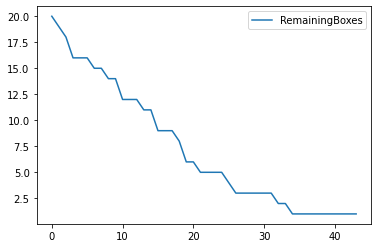

In [359]:
clean_tiles_plt = remaining_boxes[remaining_boxes["RemainingBoxes"] > 0].plot()

In [360]:
%%capture
fig, axs = plt.subplots(figsize=(8,8))
axs.set_xticks([])
axs.set_yticks([])
cmap = matplotlib.cm.get_cmap('viridis', 4) # Puede ser cualquier otra
cmap = cmap(np.linspace(0, 1, 4))
cmap[0] = np.array([256/256, 256/256, 256/256, 1]) # Piso
cmap[1] = np.array([154/256, 123/256, 79/256, 1]) # Caja
cmap[2] = np.array([000/256, 000/256, 000/256, 1]) # Estantería
cmap[3] = np.array([180/256, 180/256, 180/256, 1]) # Robot

new_cmap = matplotlib.colors.ListedColormap(cmap)
patch = plt.imshow(all_grid.iloc[0][0], cmap=new_cmap)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=NUM_GEN_AUX)

In [361]:
anim